In [28]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns

In [60]:
#define utilities functions

def downcast_dtypes(df):
    """
    Downsize float64/int64 with float32/int32 to save memory space
    """
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype in ["int64"]]

    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)

    return df

def one_hot_encoder(df, nan_as_category = True):
    """
    One-hot encoding for categorical columns with get_dummies
    """
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def process_cc_with_period(df,last_month_nums):
    '''
    Parameter:
    df: pos dataframe
    last_month_nums: last number of months
    
    Output:
    processed bureau balancing dataframe for specific period (month_nums)
    '''
    crit = df['MONTHS_BALANCE']>-last_month_nums
    df=df[crit]
    curr_column_header_list = [col for col in df.columns if 'SK_DPD' in col or 'AMT' in col or 'CNT' in col]
    new_column_header_list = ['CC_'+col+'_'+str(last_month_nums)+'MONTH' for col in df.columns if 'SK_DPD' in col or 'AMT' in col or 'CNT' in col]
    column_dict = dict(zip(curr_column_header_list,new_column_header_list))
    #print(column_dict)
    #print(df.columns)
    df.rename(columns=column_dict,inplace=True)
    #print(df.columns)
    aggregation = dict(zip(new_column_header_list,[['mean','var','min','max']]*len(new_column_header_list)))
    #print(aggregation)
    df = df.groupby('curr_app_id').agg(aggregation).reset_index()
    return df

In [83]:
cc = pd.read_csv('../input/credit_card_balance.zip')
cc, categorical_columns = one_hot_encoder(cc, nan_as_category= True)

In [84]:
categorical_columns

['NAME_CONTRACT_STATUS_Active',
 'NAME_CONTRACT_STATUS_Approved',
 'NAME_CONTRACT_STATUS_Completed',
 'NAME_CONTRACT_STATUS_Demand',
 'NAME_CONTRACT_STATUS_Refused',
 'NAME_CONTRACT_STATUS_Sent proposal',
 'NAME_CONTRACT_STATUS_Signed',
 'NAME_CONTRACT_STATUS_nan']

## Feature Engineering
### Add new features

In [85]:
cc['AMT_BALANCE_CREDIT_RATIO'] = (cc['AMT_BALANCE']/(cc['AMT_CREDIT_LIMIT_ACTUAL']+0.00001)).clip(-2,2)
cc['AMT_CREDIT_USE_RATIO'] = (cc['AMT_DRAWINGS_CURRENT']/(cc['AMT_CREDIT_LIMIT_ACTUAL']+0.00001)).clip(-2,2)
cc['AMT_DRAWING_CREDIT_USE_RATIO'] = (cc['AMT_DRAWINGS_CURRENT']/(cc['AMT_CREDIT_LIMIT_ACTUAL']+0.00001)).clip(-2,2)

<AxesSubplot:ylabel='Density'>

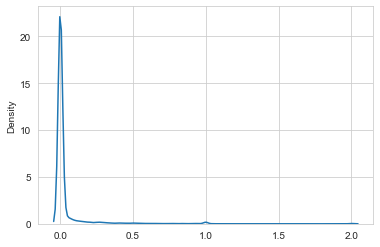

In [86]:
sns.set_style('whitegrid')
cc_sample = cc.sample(10000)
sns.kdeplot(np.array(cc_sample['AMT_CREDIT_USE_RATIO']), bw=0.1)

### Data Aggregation

In [109]:
cc.drop(['prev_app_id'], axis= 1, inplace = True)
cc_agg = cc.groupby('curr_app_id').agg([ 'max', 'mean', 'sum', 'var'])

In [110]:
cc_agg.columns = ['CC_' + col[0] + "_" + col[1].upper() for col in cc_agg.columns.tolist()]

In [111]:
cc_agg=cc_agg.reset_index()

In [112]:
cc_last_6_month = process_cc_with_period(cc,6)
cc_last_6_month.columns = ['CC_' + col[0] + "_" + col[1].upper() for col in cc_last_6_month.columns.tolist()]
cc_last_6_month.rename(columns={'CC_curr_app_id_':'curr_app_id'},inplace=True)
cc_last_12_month = process_cc_with_period(cc,12)
cc_last_12_month.columns = ['CC_' + col[0] + "_" + col[1].upper() for col in cc_last_12_month.columns.tolist()]
cc_last_12_month.rename(columns={'CC_curr_app_id_':'curr_app_id'},inplace=True)

In [113]:
cc_agg=cc_agg.merge(cc_last_6_month,how='left')
cc_agg=cc_agg.merge(cc_last_12_month,how='left')

In [114]:
cc_agg.columns

Index(['curr_app_id', 'CC_MONTHS_BALANCE_MAX', 'CC_MONTHS_BALANCE_MEAN',
       'CC_MONTHS_BALANCE_SUM', 'CC_MONTHS_BALANCE_VAR', 'CC_AMT_BALANCE_MAX',
       'CC_AMT_BALANCE_MEAN', 'CC_AMT_BALANCE_SUM', 'CC_AMT_BALANCE_VAR',
       'CC_AMT_CREDIT_LIMIT_ACTUAL_MAX',
       ...
       'CC_CC_AMT_BALANCE_CREDIT_RATIO_12MONTH_MIN',
       'CC_CC_AMT_BALANCE_CREDIT_RATIO_12MONTH_MAX',
       'CC_CC_AMT_CREDIT_USE_RATIO_12MONTH_MEAN',
       'CC_CC_AMT_CREDIT_USE_RATIO_12MONTH_VAR',
       'CC_CC_AMT_CREDIT_USE_RATIO_12MONTH_MIN',
       'CC_CC_AMT_CREDIT_USE_RATIO_12MONTH_MAX',
       'CC_CC_AMT_DRAWING_CREDIT_USE_RATIO_12MONTH_MEAN',
       'CC_CC_AMT_DRAWING_CREDIT_USE_RATIO_12MONTH_VAR',
       'CC_CC_AMT_DRAWING_CREDIT_USE_RATIO_12MONTH_MIN',
       'CC_CC_AMT_DRAWING_CREDIT_USE_RATIO_12MONTH_MAX'],
      dtype='object', length=301)

In [115]:
cc_agg.info(verbose=True,memory_usage=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103558 entries, 0 to 103557
Data columns (total 301 columns):
 #    Column                                           Non-Null Count   Dtype  
---   ------                                           --------------   -----  
 0    curr_app_id                                      103558 non-null  int64  
 1    CC_MONTHS_BALANCE_MAX                            103558 non-null  int64  
 2    CC_MONTHS_BALANCE_MEAN                           103558 non-null  float64
 3    CC_MONTHS_BALANCE_SUM                            103558 non-null  int64  
 4    CC_MONTHS_BALANCE_VAR                            102866 non-null  float64
 5    CC_AMT_BALANCE_MAX                               103558 non-null  float64
 6    CC_AMT_BALANCE_MEAN                              103558 non-null  float64
 7    CC_AMT_BALANCE_SUM                               103558 non-null  float64
 8    CC_AMT_BALANCE_VAR                               102866 non-null  float64
 9    CC

In [116]:
cc_agg.to_csv('../staging/credit_card_balance.csv', index=False, compression='zip')